In [1]:
import os
import glob
base_dir = os.path.join('F:/0Sem 7/ML Lab/flower dataset/flowers')
daisy_dir = os.path.join(base_dir,'daisy')
dandelion_dir = os.path.join(base_dir,'dandelion')
rose_dir=os.path.join(base_dir,'rose')
sunflower_dir=os.path.join(base_dir,'sunflower')
tulip_dir=os.path.join(base_dir,'tulip')
daisy_files = glob.glob(daisy_dir+'/*.jpg')
dandelion_files = glob.glob(dandelion_dir+'/*.jpg')
rose_files = glob.glob(rose_dir+'/*.jpg')
sunflower_files = glob.glob(sunflower_dir+'/*.jpg')
tulip_files = glob.glob(tulip_dir+'/*.jpg')
print("Daisy samples:",len(daisy_files))
print("Dandelion samples:",len(dandelion_files))
print("Rose samples:",len(rose_files))
print("Sunflower samples:",len(sunflower_files))
print("Tulip samples:",len(tulip_files))

Daisy samples: 769
Dandelion samples: 1052
Rose samples: 784
Sunflower samples: 734
Tulip samples: 984


In [2]:
import numpy as np
import pandas as pd

np.random.seed(42)

files_df = pd.DataFrame({
    'filename': daisy_files + dandelion_files + rose_files + sunflower_files + tulip_files,
    'label': ['daisy'] * len(daisy_files) + ['dandelion'] * len(dandelion_files) + ['rose'] * len(rose_files) + ['sunflower'] * len(sunflower_files) + ['tulip'] * len(tulip_files)
}).sample(frac=1, random_state=42).reset_index(drop=True)

files_df.head()

,filename,label
0,F:/0Sem 7/ML Lab/flower dataset/flowers\dandel...,dandelion
1,F:/0Sem 7/ML Lab/flower dataset/flowers\dandel...,dandelion
2,F:/0Sem 7/ML Lab/flower dataset/flowers\dandel...,dandelion
3,F:/0Sem 7/ML Lab/flower dataset/flowers\tulip\...,tulip
4,F:/0Sem 7/ML Lab/flower dataset/flowers\rose\4...,rose


In [3]:
files_df=files_df.sample(frac=1)
files_df=files_df.reset_index(drop=True)
files_df.head()

,filename,label
0,F:/0Sem 7/ML Lab/flower dataset/flowers\tulip\...,tulip
1,F:/0Sem 7/ML Lab/flower dataset/flowers\dandel...,dandelion
2,F:/0Sem 7/ML Lab/flower dataset/flowers\sunflo...,sunflower
3,F:/0Sem 7/ML Lab/flower dataset/flowers\rose\9...,rose
4,F:/0Sem 7/ML Lab/flower dataset/flowers\dandel...,dandelion


In [4]:
from sklearn.model_selection import train_test_split
from collections import Counter
train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=0.1, random_state=42)

print(train_files.shape, test_files.shape)
print('Train:', Counter(train_labels), '\nTest:', Counter(test_labels))

(3890,) (433,)
Train: Counter({'dandelion': 956, 'tulip': 870, 'rose': 700, 'daisy': 698, 'sunflower': 666}) 
Test: Counter({'tulip': 114, 'dandelion': 96, 'rose': 84, 'daisy': 71, 'sunflower': 68})


In [5]:
import cv2
from concurrent import futures
import threading

IMG_DIMS = (80, 80)

def get_img_data_parallel(idx, img, total_imgs):
    if idx % 1000 == 0 or idx == (total_imgs - 1):
        print('{}: working on img num: {}'.format(threading.current_thread().name,
                                                  idx))
    img = cv2.imread(img)
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)   #colour to grey
    img = cv2.resize(img, dsize=IMG_DIMS, 
                     interpolation=cv2.INTER_CUBIC)
    img = np.array(img, dtype=np.float32)
    return img

ex = futures.ThreadPoolExecutor(max_workers=None)
train_data_inp = [(idx, img, len(train_files)) for idx, img in enumerate(train_files)]
test_data_inp = [(idx, img, len(test_files)) for idx, img in enumerate(test_files)]

print('Loading Train Images:')
train_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in train_data_inp],
                        [record[1] for record in train_data_inp],
                        [record[2] for record in train_data_inp])
train_data = np.array(list(train_data_map))

print('\nLoading Test Images:')
test_data_map = ex.map(get_img_data_parallel, 
                        [record[0] for record in test_data_inp],
                        [record[1] for record in test_data_inp],
                        [record[2] for record in test_data_inp])
test_data = np.array(list(test_data_map))

train_data.shape, test_data.shape

Loading Train Images:
ThreadPoolExecutor-0_0: working on img num: 0
ThreadPoolExecutor-0_18: working on img num: 1000
ThreadPoolExecutor-0_8: working on img num: 2000
ThreadPoolExecutor-0_3: working on img num: 3000
ThreadPoolExecutor-0_3: working on img num: 3889

Loading Test Images:
ThreadPoolExecutor-0_1: working on img num: 0
ThreadPoolExecutor-0_1: working on img num: 432


((3890, 80, 80, 3), (433, 80, 80, 3))

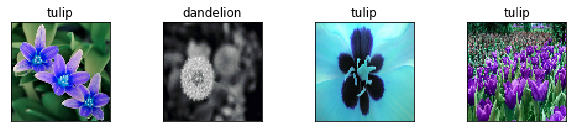

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(1 , figsize = (10 , 10))
n = 0 
for i in range(4):
    n += 1 
    r = np.random.randint(0 , train_data.shape[0] , 1)
    plt.subplot(4 , 4 , n)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(train_data[r[0]]/255.)
    plt.title('{}'.format(train_labels[r[0]]))
    plt.xticks([]) , plt.yticks([])

In [7]:
BATCH_SIZE = 100
NUM_CLASSES = 5
EPOCHS = 25
INPUT_SHAPE = (80, 80, 3)

# encode text category labels
from sklearn.preprocessing import LabelEncoder

train_imgs_scaled = train_data / 255.
test_imgs_scaled = test_data / 255.

le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
test_labels_enc = le.transform(test_labels)

from keras.utils import to_categorical
train_labels_enc=to_categorical(train_labels_enc)
test_labels_enc=to_categorical(test_labels_enc)

print(train_labels[:4], train_labels_enc[:4])
print(test_labels[:4], test_labels_enc[:4])

Using TensorFlow backend.


['daisy' 'rose' 'rose' 'sunflower'] [[1. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]]
['rose' 'tulip' 'rose' 'dandelion'] [[0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [12]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
def build_model():
    model=Sequential()
    model.add(layers.Conv2D(16, (5,5), activation='relu', input_shape=INPUT_SHAPE))
    model.add(layers.Dropout(rate=0.8))
    #model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(32, (4,4), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Conv2D(64, (3,3), activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D())
    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(5, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    return model

In [13]:
model=build_model()
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 76, 76, 16)        1216      
_________________________________________________________________
dropout_1 (Dropout)          (None, 76, 76, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 73, 73, 32)        8224      
_________________________________________________________________
batch_normalization_2 (Batch (None, 73, 73, 32)        128       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 34, 34, 64)       

In [14]:
history = model.fit(x=train_imgs_scaled, y=train_labels_enc, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, 
                    validation_data=(test_imgs_scaled, test_labels_enc),
                    verbose=1)

Train on 3890 samples, validate on 433 samples
Epoch 1/25
3890/3890 [==============================] - 6s 1ms/sample - loss: 3.5399 - accuracy: 0.6872 - val_loss: 2.3052 - val_accuracy: 0.7109
Epoch 2/25
3890/3890 [==============================] - 4s 923us/sample - loss: 1.8169 - accuracy: 0.7463 - val_loss: 4.7819 - val_accuracy: 0.6887
Epoch 3/25
3890/3890 [==============================] - 4s 928us/sample - loss: 0.6664 - accuracy: 0.7951 - val_loss: 4.7508 - val_accuracy: 0.6896
Epoch 4/25
3890/3890 [==============================] - 4s 923us/sample - loss: 0.4581 - accuracy: 0.8235 - val_loss: 4.7037 - val_accuracy: 0.6915
Epoch 5/25
3890/3890 [==============================] - 4s 929us/sample - loss: 0.3905 - accuracy: 0.8400 - val_loss: 4.5978 - val_accuracy: 0.6970
Epoch 6/25
3890/3890 [==============================] - 4s 931us/sample - loss: 0.3913 - accuracy: 0.8482 - val_loss: 4.2779 - val_accuracy: 0.7058
Epoch 7/25
3890/3890 [==============================] - 4s 925us/sa

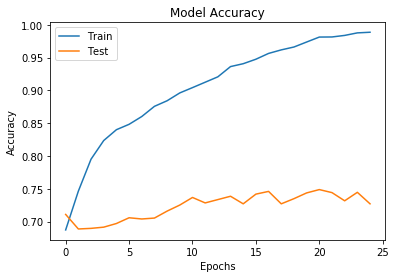

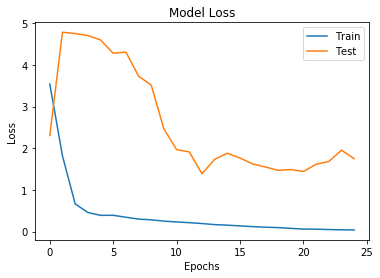

In [15]:
# Plot the model accuracy vs. number of Epochs
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()

# Plot the Loss function vs. number of Epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Train', 'Test'])
plt.show()